# GPU Computing for Data Scientists
#### Using CUDA, Jupyter, PyCUDA, ArrayFire and Thrust


https://github.com/QuantScientist/Data-Science-ArrayFire-GPU

In [1]:
# !pip install pycuda
%reset -f
import pycuda
from pycuda import compiler
import pycuda.driver as cuda
import numpy
import numpy as np

from pycuda.compiler import SourceModule

cuda.init()
print("%d device(s) found." % cuda.Device.count())           
for ordinal in range(cuda.Device.count()):
    dev = cuda.Device(ordinal)
    print "Device #%d: %s" % (ordinal, dev.name())    

print cuda

1 device(s) found.
Device #0: GeForce GTX 1080
<module 'pycuda.driver' from '/usr/local/lib/python2.7/dist-packages/pycuda/driver.pyc'>


## Sigmoid on the GPU

In [5]:
# %%writefile xxx.py
import pycuda.autoinit

a = numpy.random.randn(4,4)
a = a.astype(numpy.float32)

a_gpu = cuda.mem_alloc(a.nbytes)

cuda.memcpy_htod(a_gpu, a)

mod = SourceModule("""
  #include <stdio.h>
  
  __global__ void sigmoid(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] =idx;
    //printf("indice x: %d, indice y: %d\\n", threadIdx.x, threadIdx.y);
  }
  """)

# ForwardSigmoid = SourceModule("""
# 	__global__ void sigmoid(float *s, float *xout)
#     {
# 	// this applies the sigmoid function
# 	xout[threadIdx.x] = (1 - exp(-2*s[threadIdx.x])) / (1 + exp(-2*s[threadIdx.x]));
#     }
#     """)
  
func = mod.get_function("sigmoid")
func(a_gpu, block=(8,4,1))

a_sigmoid = numpy.empty_like(a)
cuda.memcpy_dtoh(a_sigmoid, a_gpu)
print a_sigmoid

[[  0.   1.   2.   3.]
 [  4.   5.   6.   7.]
 [  8.   9.  10.  11.]
 [ 12.  13.  14.  15.]]


In [6]:
import pycuda.autoinit

# a = np.random.uniform(low=1, high=20, size=(10,))

# a = numpy.random.randn(1,9)
a = np.arange(-10, 10, 1)
a = a.astype(numpy.float32)
print a


size = numpy.int32(a.shape[-1])
print size 

a_gpu = cuda.mem_alloc(a.nbytes)
xout_gpu = cuda.mem_alloc(a.nbytes)

cuda.memcpy_htod(a_gpu, a)
xout_gpu=cuda.mem_alloc_like(a)
# size_gpu=cuda.mem_alloc_like(size)

mod = SourceModule("""  
  
  __global__ void sigmoid(float* a, float* b, int size)
    {
        int index = blockDim.x * blockIdx.x + threadIdx.x;
        if (index < size)
            b[index] = 1.0f / (1.0f + exp(-1.0f * a[index]));
    }
  """)

# s_gpu=size.astype(numpy.int32)

func = mod.get_function("sigmoid")
func(a_gpu, xout_gpu,size, block=(20,1,1))

a_sigmoid = numpy.empty_like(a)
cuda.memcpy_dtoh(a_sigmoid, xout_gpu)
print a_sigmoid

from scipy.special import expit
y = expit(a)
print ("__________________________________")
print y

[-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.
   5.   6.   7.   8.   9.]
20
[  4.53978682e-05   1.23394580e-04   3.35350138e-04   9.11051175e-04
   2.47262302e-03   6.69285096e-03   1.79862101e-02   4.74258736e-02
   1.19202919e-01   2.68941432e-01   5.00000000e-01   7.31058598e-01
   8.80797029e-01   9.52574134e-01   9.82013762e-01   9.93307173e-01
   9.97527421e-01   9.99089003e-01   9.99664664e-01   9.99876618e-01]
__________________________________
[  4.53978719e-05   1.23394580e-04   3.35350138e-04   9.11051175e-04
   2.47262302e-03   6.69285096e-03   1.79862101e-02   4.74258736e-02
   1.19202919e-01   2.68941432e-01   5.00000000e-01   7.31058598e-01
   8.80797029e-01   9.52574134e-01   9.82013762e-01   9.93307173e-01
   9.97527421e-01   9.99089003e-01   9.99664664e-01   9.99876618e-01]


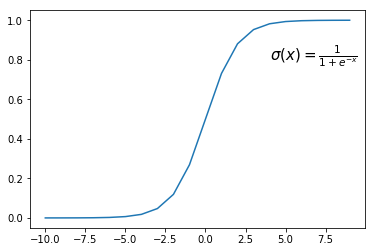

In [7]:
import matplotlib.pyplot as plt

plt.plot(a,a_sigmoid)
plt.text(4,0.8,r'$\sigma(x)=\frac{1}{1+e^{-x}}$',fontsize=15)
plt.legend(loc='lower right')
plt.show()